In [1]:
import numpy as np
import segyio

def segment_segy_into_streamlines(sgyfile):
    """
    Reads a SEG-Y file and segments it into individual streamlines.
    
    Args:
    sgyfile (str): Path to the SEG-Y file
    
    Returns:
    tuple: Containing data output, sample interval, segmented data, samples, info
    """
    segmented_data = []
    samples = None

    with segyio.open(sgyfile, "r", ignore_geometry=True) as f:
        num_traces = f.tracecount
        num_samples = f.samples.size

        # Initialize data array
        dataout = np.zeros((num_traces, num_samples))

        # Populate the data array with traces
        for i in range(num_traces):
            dataout[i, :] = f.trace[i]

        # Extracting sample interval
        sampint = f.samples[1] - f.samples[0]
        samples = f.samples

        # Segment the data into streamlines
        traces_per_streamline = 638
        streamlines_per_shot = 8
        traces_per_shot = traces_per_streamline * streamlines_per_shot

        for i in range(num_traces // traces_per_shot):
            start_index = i * traces_per_shot
            for j in range(streamlines_per_shot):
                streamline_data = dataout[start_index + j * traces_per_streamline: start_index + (j + 1) * traces_per_streamline, :]
                segmented_data.append(streamline_data)

    return dataout, sampint, segmented_data, samples

In [2]:
import matplotlib.pyplot as plt

def plot_streamline(dataout, sampint, streamline_index):
    """
    Plots time vs receiver number for a specific streamline, indicating amplitude
    with colors (blue for positive and red for negative).

    Args:
    dataout (list of numpy.ndarray): The output data of traces for the specific streamline
    sampint (float): Sample interval
    streamline_index (int): Index of the streamline to plot
    """
    
    # Gather the specific streamline to plot
    specific_streamline_data = dataout[streamline_index]
    
    num_receivers = specific_streamline_data.shape[0]
    num_samples = specific_streamline_data.shape[1]

    # Create a time vector based on the sample interval
    time_vector = np.arange(0, num_samples * sampint, sampint)

    # Create a figure for the plot
    plt.figure(figsize=(12, 8))

    # Plot the traces for the specified streamline
    for receiver in range(num_receivers):
        amplitude = specific_streamline_data[receiver, :]
        color = 'blue' if np.max(amplitude) > 0 else 'red'
        plt.plot(time_vector, amplitude, color=color, alpha=0.6)
    
    # Labeling the plot
    plt.title(f'Time vs Receiver Number for Streamline {streamline_index + 1}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

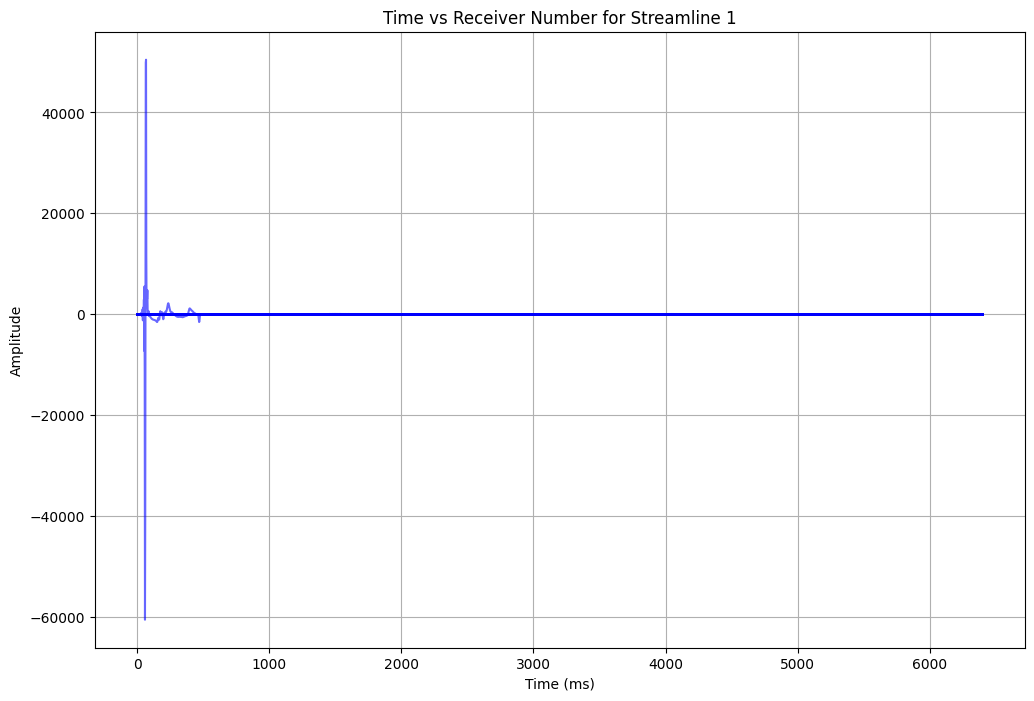

In [3]:
# Example usage
data_file = r"D:\Zou\3DSO\PRO\SO_DataProcessing\1902_raw_data_analysis\R1809SA8S299.sgy"  # Path to the SEG-Y file
dataout, sampint, segmented_data, samples = segment_segy_into_streamlines(data_file)

# Specify which streamline to plot
streamline_index = 0  # Change this to plot different streamlines (0 to 7)

# Plot the specific streamline
plot_streamline(segmented_data, sampint, streamline_index)

In [5]:
import segyio
import numpy as np

def read_segy_file(file_path, shot_index):
    """
    Reads a SEG-Y file and extracts data for a specified shot.
    
    Args:
    file_path (str): Path to the SEG-Y file.
    shot_index (int): Index of the shot to extract (0 for first shot).
    
    Returns:
    numpy.ndarray: Amplitude data for the shot.
    float: Sample interval in seconds.
    """
    
    traces_per_shot = 5105  # Total traces for each shot
    
    with segyio.open(file_path, "r", ignore_geometry=True) as f:
        total_traces = f.tracecount  # Total traces in file
        sample_interval = f.samples[1] - f.samples[0]  # Sample interval
        
        if shot_index * traces_per_shot >= total_traces:
            raise IndexError("Shot index out of range.")
        
        # Extract the data for the specified shot
        shot_start_index = shot_index * traces_per_shot
        shot_data = np.zeros((traces_per_shot, 3200))
        
        for i in range(traces_per_shot):
            shot_data[i, :] = f.trace[shot_start_index + i]
    
    return shot_data, sample_interval

In [6]:
def organize_streamlines(shot_data):
    """
    Organizes shot data into streamlines.
    
    Args:
    shot_data (numpy.ndarray): Amplitude data for the shot.
    
    Returns:
    list: List of streamlines, where each streamline is a 2D numpy array.
    """
    
    streamlines_per_shot = 8  # Number of streamlines per shot
    receivers_per_streamline = 638  # Number of receivers in each streamline
    segmented_streamlines = []

    for s in range(streamlines_per_shot):  # Loop through the streamlines
        start_index = s * receivers_per_streamline
        streamline_data = shot_data[start_index:start_index + receivers_per_streamline, :]
        segmented_streamlines.append(streamline_data)
    
    return segmented_streamlines

In [7]:
import matplotlib.pyplot as plt

def plot_streamline(segmented_streamlines, streamline_index, sample_interval):
    """
    Plots time versus receiver number for a selected streamline.
    
    Args:
    segmented_streamlines (list): List of streamlines data.
    streamline_index (int): Index of the streamline to be plotted.
    sample_interval (float): Sample interval in seconds.
    """
    
    # Gather the specific streamline to plot
    selected_streamline_data = segmented_streamlines[streamline_index]
    num_receivers = selected_streamline_data.shape[0]
    num_samples = selected_streamline_data.shape[1]
    time_vector = np.arange(0, num_samples * sample_interval, sample_interval)  # Time vector in seconds
    
    plt.figure(figsize=(12, 8))
    
    for receiver in range(num_receivers):
        amplitude = selected_streamline_data[receiver, :]
        color = 'red' if np.mean(amplitude) < 0 else 'blue'  # Color based on average amplitude
        plt.plot(time_vector, amplitude, color=color, alpha=0.6)
    
    plt.title(f'Time vs Receiver Number for Streamline {streamline_index + 1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

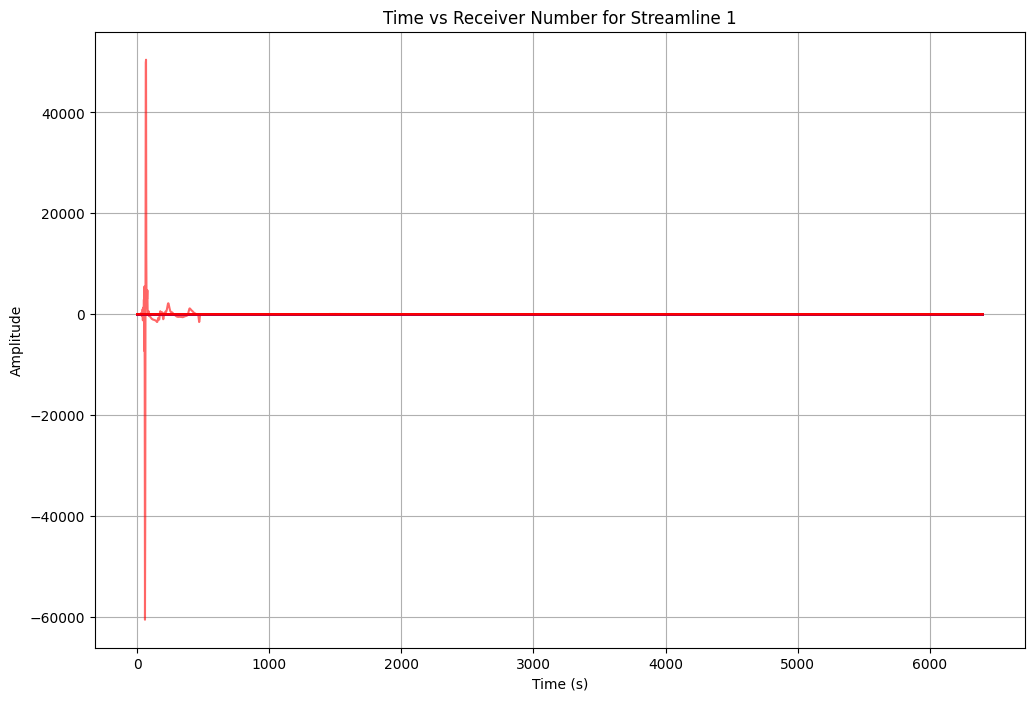

In [8]:
# Example usage
data_file = r"D:\Zou\3DSO\PRO\SO_DataProcessing\1902_raw_data_analysis\R1809SA8S299.sgy"  # Path to the SEG-Y file
shot_index = 0  # Specify the shot index (0 for the first shot)
streamline_index = 0  # Specify the streamline index (0 to 7)

# Read the SEG-Y file
shot_data, sample_interval = read_segy_file(data_file, shot_index)

# Segment the shot data into streamlines
segmented_streamlines = organize_streamlines(shot_data)

# Plot the selected streamline
plot_streamline(segmented_streamlines, streamline_index, sample_interval)